In [1]:
from __future__ import print_function
import os,re,time,sys,os,math,random,time,pickle,keras
#import pydot_ng as pydot
#import pydot
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import pandas as pd
from keras import backend as K
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Flatten,Dense,Embedding
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
%matplotlib inline
from sklearn.model_selection import train_test_split as split
start = time.time()

Using TensorFlow backend.


In [2]:
if os.name != 'posix':
    f = open(r'M:\Course stuff\ASPRI\data\PCH\paths\11012018.txt','r')
else:
    f = open('../data/PCH/paths/11012018.txt','r')
lines = f.readlines()
lines = [i.strip() for i in lines]

In [3]:
if os.name != 'posix':
    final_embeddings = pickle.load(open(r'M:\Course stuff\ASPRI\supervised\loal_FE','rb'))
    dictionary = pickle.load(open(r'M:\Course stuff\ASPRI\supervised\dictionary','rb'))
    reverse_dictionary = pickle.load(open(r'M:\Course stuff\ASPRI\supervised\reverse_dictionary','rb'))
    count = pickle.load(open(r'M:\Course stuff\ASPRI\supervised\count','rb'))
else:
    final_embeddings = pickle.load(open('gcp_fe','rb'))
    dictionary = pickle.load(open('gcp_dictionary','rb'))
    reverse_dictionary = pickle.load(open('gcp_reverse_dictionary','rb'))
    count = pickle.load(open('gcp_count','rb'))
print(type(final_embeddings),type(dictionary),type(reverse_dictionary),type(count))

<class 'numpy.ndarray'> <class 'dict'> <class 'dict'> <class 'list'>


In [4]:
original_gcp_fe = final_embeddings.copy()

In [5]:
nd_array = []
for i in range(30):
    nd_array.append(np.zeros(shape = (32,1)))

In [6]:
len(nd_array)

30

In [7]:
dictionary['55628']

2618

In [8]:
new_array = []
for i in range(len(lines)):
    new_array.append(nd_array)
new_array = np.asarray(new_array)

In [9]:
for i in range(len(lines)):
    splits = lines[i].split(' ')
    for j in range(len(splits)):
        #print(new_array[i][j])
        new_array[i,j] = final_embeddings[dictionary[str(splits[j])]-1].reshape(32,1)

In [10]:
new_array[0][0].shape

(32, 1)

In [11]:
if os.name != 'posix':
    paths = pd.read_csv(r'M:\Course stuff\ASPRI\supervised\11012018.csv',sep='\t',low_memory = False,index_col = False)
else:
    paths = pd.read_csv('11012018.csv',sep='\t',low_memory = False,index_col = False)
    del paths['Unnamed: 0']
paths.head()

,Paths,Fake
0,6939 4826 38803 56203,0.0
1,6939 4826 38803 56203,0.0
2,6939 4826 38803 56203,0.0
3,6939 4826 38803 56203,0.0
4,6939 4826 38803 56203,0.0


In [12]:
train,test = split(paths,test_size = 0.3)

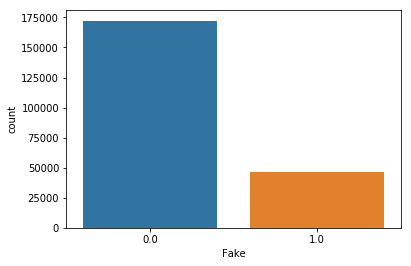

In [13]:
sns.countplot(x = 'Fake',data = train)

In [14]:
train.Fake.value_counts()

0.0    172255
1.0     46701
Name: Fake, dtype: int64

In [15]:
test.Fake.value_counts()

0.0    74075
1.0    19764
Name: Fake, dtype: int64

In [16]:
max_length = 30
vocab_size = 24612 #unique tokens for this file
#encoded_train = [one_hot(d,vocab_size) for d in train['Paths']]
#encoded_test = [one_hot(d,vocab_size) for d in test['Paths']]

In [17]:
def encode_lines(arr):
    # function works on df
    # iterate over lines in df
    # iterate over splits of line
    # convert split word to embedding vector (32,1)
    # pad with (32,1) zeros
    
    
    new_array = []
    for i in range(len(arr)):
        new_array.append(nd_array)
    new_array = np.asarray(new_array)
    c = 0
    for i in arr['Paths']:
        splits = i.split(' ')
        for j in range(len(splits)):
            #print(new_array[i][j])
            new_array[c,j] = final_embeddings[dictionary[str(splits[j])]-1].reshape(32,1)
        c += 1
    assert(len(new_array) == len(arr))
    assert(len(new_array[0]) == 30)
    return new_array
encoded_train = encode_lines(train)

In [18]:
len(encoded_train)

218956

In [19]:
encoded_test = encode_lines(test)

In [20]:
train_lengths = [len(t) for t in encoded_train] #array of lengths so we can pad zeros later
test_lengths= [len(t) for t in encoded_test] #array of lengths for test set to be padded later

In [21]:
y_test,y_train = test['Fake'],train['Fake']

In [22]:
x_train = encode_lines(train)#['Paths'])
x_test = encode_lines(test)#['Paths'])

In [23]:
max_length = 30
vocab_size = 24612 #unique tokens for this file
encoded_train = [one_hot(d,vocab_size) for d in train['Paths']]
encoded_test = [one_hot(d,vocab_size) for d in test['Paths']]
train_lengths = [len(t) for t in encoded_train] #array of lengths so we can pad zeros later
test_lengths= [len(t) for t in encoded_test] #array of lengths for test set to be padded later

In [24]:
labels_train = train['Fake']
train_dic={}
train_dic["data"] = encoded_train
train_dic["labels"] = labels_train#labels_train[0].ravel().tolist()
train_dic["length"] = train_lengths
train_len = len(train)
test_len = len(test)

train_ = pd.DataFrame.from_dict(data=train_dic, orient='columns', dtype=None)



test_dic={}
test_dic["data"] = encoded_test
test_dic["length"] = test_lengths
test_dic["labels"] = test['Fake']
test_ = pd.DataFrame.from_dict(data=test_dic, orient='columns', dtype=None)

test_input = test.values

In [25]:
x_train, x_test = train_["data"],test_["data"]
y_train,y_test = train['Fake'],test['Fake']

In [26]:
max_features = vocab_size
maxlen = 30  # cut texts after this number of words (among top max_features most common words)
batch_size = 1024
epochs = 10 #training steps
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

218956 train sequences
93839 test sequences
Pad sequences (samples x time)
x_train shape: (218956, 30)
x_test shape: (93839, 30)


In [27]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          787584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 795,175
Trainable params: 795,175
Non-trainable params: 0
_________________________________________________________________
Train...
93839/93839 [==============================] - 1s 13us/step
Test score: 0.15832785122514725
Test accuracy: 0.9600059678071315


In [28]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(keras.layers.GRU(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 0,
          validation_data=(x_test, y_test))
score_gru_sigmoid_FC, acc_gru_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_gru_sigmoid_FC)
print('Test accuracy:', acc_gru_sigmoid_FC)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          787584    
_________________________________________________________________
gru_1 (GRU)                  (None, 30)                5670      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 793,285
Trainable params: 793,285
Non-trainable params: 0
_________________________________________________________________
Train...
93839/93839 [==============================] - 1s 11us/step
Test score: 0.15771469879242364
Test accuracy: 0.9608158655815983


In [29]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='tanh'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 0,
          validation_data=(x_test, y_test))
score_lstm_tanh_FC, acc_lstm_tanh_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_tanh_FC)
print('Test accuracy:', acc_lstm_tanh_FC)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          787584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 795,175
Trainable params: 795,175
Non-trainable params: 0
_________________________________________________________________
Train...
93839/93839 [==============================] - 1s 13us/step
Test score: 0.26216658560057976
Test accuracy: 0.9349630749746846


In [30]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 0,
          validation_data=(x_test, y_test))
score_lstm_relu_FC, acc_lstm_relu_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_relu_FC)
print('Test accuracy:', acc_lstm_relu_FC)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          787584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 795,175
Trainable params: 795,175
Non-trainable params: 0
_________________________________________________________________
Train...
93839/93839 [==============================] - 1s 14us/step
Test score: 0.2760800119290898
Test accuracy: 0.8409190209149275


In [31]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='elu'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 0,
          validation_data=(x_test, y_test))
score_lstm_elu_FC, acc_lstm_elu_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_elu_FC)
print('Test accuracy:', acc_lstm_elu_FC)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          787584    
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 31        
Total params: 795,175
Trainable params: 795,175
Non-trainable params: 0
_________________________________________________________________
Train...
93839/93839 [==============================] - 1s 13us/step
Test score: 0.2844299603579966
Test accuracy: 0.840151749369873


In [32]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
#model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))
model.add(Dense(1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 0,
          validation_data=(x_test, y_test))
score_lstm_3FC_02dropout, acc_lstm_3FC_02dropout = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_3FC_02dropout)
print('Test accuracy:', acc_lstm_3FC_02dropout)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          787584    
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2         
Total params: 795,179
Trainable params: 795,179
Non-trainable params: 0
_________________________________________________________________
Train...
93839/93839 [==============================] - 1s 14us/step
Test score: 0.51713466147767
Test accuracy: 0.788350

In [33]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(30, dropout=0.8, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))
model.add(Dense(1, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_3FC, acc_lstm_3FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_3FC)
print('Test accuracy:', acc_lstm_3FC)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          787584    
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 2         
Total params: 795,179
Trainable params: 795,179
Non-trainable params: 0
_________________________________________________________________
Train...
93839/93839 [==============================] - 1s 14us/step
Test score: 0.18585771658466957
Test accuracy: 0.959

In [34]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(1, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(1, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_3FC_bn, acc_lstm_3FC_bn = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_3FC_bn)
print('Test accuracy:', acc_lstm_3FC_bn)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 32)          787584    
_________________________________________________________________
lstm_7 (LSTM)                (None, 30)                7560      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 31        
_________________________________________________________________
batch_normalization_1 (Batch (None, 1)                 4         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 2         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                 4         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 2     

In [35]:
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(keras.layers.GRU(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(1, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(1, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_gru_3FC_bn, acc_gru_3FC_bn = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_gru_3FC_bn)
print('Test accuracy:', acc_gru_3FC_bn)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 32)          787584    
_________________________________________________________________
gru_2 (GRU)                  (None, 30)                5670      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 31        
_________________________________________________________________
batch_normalization_4 (Batch (None, 1)                 4         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 2         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1)                 4         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 2     

LSTM with sigmoid FC  =  0.9600059678071315 

GRU with sigmoid FC  =  0.9608158655815983 

LSTM with tanh FC  =  0.9349630749746846 

LSTM with relu FC  =  0.8409190209149275 

LSTM with elu FC  =  0.840151749369873 

Denser LSTM with 0.2 dropout  =  0.7883502593879056 

Denser LSTM with 0.8 dropout  =  0.9599633416361558 

Denser LSTM with 0.2 dropout and batchnorm  =  0.7883502593879056 

Denser GRU with 0.2 dropout and batchnorm  =  0.9620839950373683 



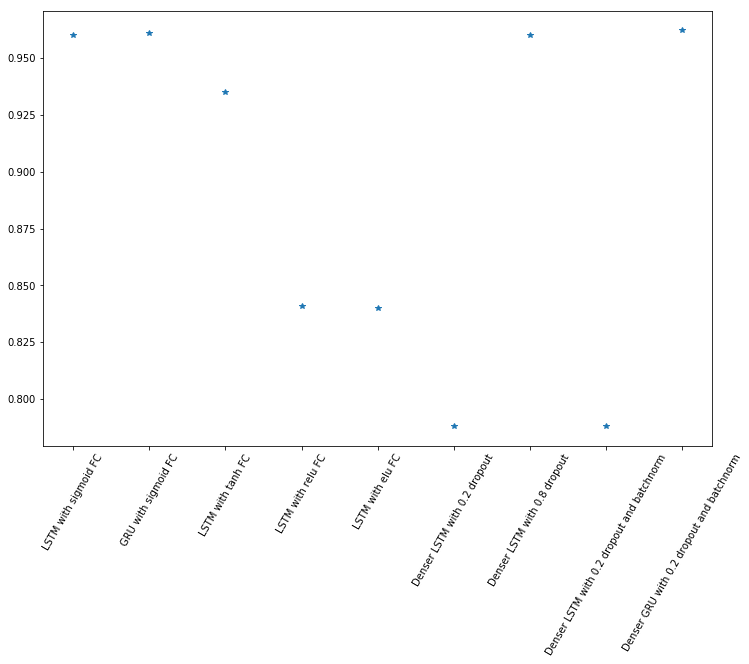

time taken for running the notebook:
 0 hours, 24.0 minutes and 12.41102385520935 seconds


In [36]:
#acc_gru_3FC_bn = 0.966
names = ['LSTM with sigmoid FC',
         'GRU with sigmoid FC',
         'LSTM with tanh FC',
         'LSTM with relu FC', 
         'LSTM with elu FC',
         'Denser LSTM with 0.2 dropout',
         'Denser LSTM with 0.8 dropout',
         'Denser LSTM with 0.2 dropout and batchnorm',
        'Denser GRU with 0.2 dropout and batchnorm']
accs = [acc_lstm_sigmoid_FC,
        acc_gru_sigmoid_FC,
        acc_lstm_tanh_FC,
        acc_lstm_relu_FC,
        acc_lstm_elu_FC,
        acc_lstm_3FC_02dropout,
        acc_lstm_3FC,
        acc_lstm_3FC_bn,
       acc_gru_3FC_bn]
for i in range(len(names)):
    print(names[i]," = ", accs[i],"\n" )
x = [i for i in range(len(names))]
plt.figure(figsize=(12,8))
pl.xticks(x, names)
pl.xticks(range(len(names)), names, rotation=60) #writes strings with 45 degree angle
pl.plot(x,accs,'*')
pl.show()
end = time.time()
seconds = end - start
minutes = seconds//60
seconds = seconds % 60
hours = 0
if minutes > 60:
    hours = minutes//60
    minutes = minutes%60
print("time taken for running the notebook:\n {0} hours, {1} minutes and {2} seconds".format(hours,minutes,seconds))

In [38]:
### search for hyperparameters ###

### IN THIS BLOCK ###

## TO CHECK: RECURRENT DROPOUT RATE ##

# CHECK 0.2, 0.8 #

batch_size = 256

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)
print('Build model...')

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.8))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)

Build model...
Train...
Train on 218956 samples, validate on 93839 samples
Epoch 1/10
218956/218956 [==============================] - 91s 416us/step - loss: 0.2932 - acc: 0.8989 - val_loss: 0.1647 - val_acc: 0.9553
Epoch 2/10
218956/218956 [==============================] - 87s 400us/step - loss: 0.1490 - acc: 0.9597 - val_loss: 0.1443 - val_acc: 0.9616
Epoch 3/10
218956/218956 [==============================] - 86s 393us/step - loss: 0.1344 - acc: 0.9631 - val_loss: 0.1433 - val_acc: 0.9621
Epoch 4/10
218956/218956 [==============================] - 87s 399us/step - loss: 0.1285 - acc: 0.9640 - val_loss: 0.1457 - val_acc: 0.9619
Epoch 5/10
218956/218956 [==============================] - 87s 396us/step - loss: 0.1246 - acc: 0.9644 - val_loss: 0.1482 - val_acc: 0.9619
Epoch 6/10
218956/218956 [==============================] - 87s 399us/step - loss: 0.1216 - acc: 0.9649 - val_loss: 0.1513 - val_acc: 0.9619
Epoch 7/10
218956/218956 [==============================] - 87s 399us/step - lo

In [28]:
### search for hyperparameters ###

### IN THIS BLOCK ###

## TO CHECK: number of LSTM units ##
# already have: 128 in github. 30 in this notebook #
# CHECK 64 #
from keras import backend as K

K.clear_session()
epochs = 5

batch_size = 32
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 1,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)
print('Build model...')

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          787584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 812,481
Trainable params: 812,481
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 218956 samples, validate on 93839 samples
Epoch 1/5
 49440/218956 [=====>........................] - ETA: 4:57 - loss: 0.3058 - acc: 0.8950

KeyboardInterrupt: 

In [ ]:
batch_size = 32
K.clear_session()
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)
print('Build model...')

In [ ]:
embedding_matrix = {}
for i in list(reverse_dictionary.keys()):
    embedding_matrix[i] = final_embeddings[i-1]

In [ ]:
final_embeddings.shape

In [ ]:
embedding_matrix = np.zeros((len(dictionary), 32))
for i in list(reverse_dictionary.keys()):
    embedding_vector = final_embeddings[i-1]#.reshape((32,1))
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i-1] = embedding_vector    

In [ ]:
len(embedding_matrix)

In [ ]:
print('Build model...')
K.clear_session()
model = Sequential()
model.add(Embedding(len(embedding_matrix), 32,weights = [embedding_matrix],trainable = False))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)

In [ ]:
#from keras.layers import TimeDistributed
print('Building w2v embedding model with denser (16 units) FC layer ...')
model = Sequential()
model.add(Embedding(len(embedding_matrix), 32,weights = [embedding_matrix],trainable = False))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)
## Adding a FC layer did not help but hurt both in terms of training and validation accuracies

In [ ]:
print('Building Trainable w2v embedding model...')
model = Sequential()
model.add(Embedding(len(embedding_matrix), 32,weights = [embedding_matrix],trainable = True))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)

In [ ]:
print('Building w2v embedding model with denser (16 units) FC layer ...')
model = Sequential()
model.add(Embedding(len(embedding_matrix), 32,weights = [embedding_matrix],trainable = False))
model.add(LSTM(30, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)
# increasing number of hidden units in dense layer helped
# ==>> extra layer with more hidden units

# try lstm : 128 -> Dense : 64 -> Dens: 1

In [ ]:
print('Building w2v embedding model with denser (16 units) FC layer and 128 hidden units in LSTM ...')
model = Sequential()
model.add(Embedding(len(embedding_matrix), 32,weights = [embedding_matrix],trainable = False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)

In [ ]:
print('Building w2v embedding model with denser (32 units) FC layer and 128 hidden units in LSTM ...')
model = Sequential()
model.add(Embedding(len(embedding_matrix), 32,weights = [embedding_matrix],trainable = False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)

In [ ]:
print('Building trainable w2v embedding model with denser (32 units) FC layer and 128 hidden units in LSTM ...')
model = Sequential()
model.add(Embedding(len(embedding_matrix), 32,weights = [embedding_matrix],trainable = True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)

In [ ]:
print('Building trainable w2v embedding model with denser (64 units) FC layer and 128 hidden units in LSTM ...')
model = Sequential()
model.add(Embedding(len(embedding_matrix), 32,weights = [embedding_matrix],trainable = True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)

In [ ]:
print('Building trainable w2v embedding model with extra units for last model ...')
model = Sequential()
model.add(Embedding(len(embedding_matrix), 32,weights = [embedding_matrix],trainable = True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,verbose = 0,validation_data=(x_test, y_test))
score_lstm_sigmoid_FC, acc_lstm_sigmoid_FC = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score_lstm_sigmoid_FC)
print('Test accuracy:', acc_lstm_sigmoid_FC)

In [ ]:
print('Building trainable w2v embedding model with extra units for last model ...')
model = Sequential()
model.add(Embedding(len(embedding_matrix), 32,weights = [embedding_matrix],trainable = True))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(128, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])